In [30]:
import pytorch_lightning as pl
from src.srgan import SRGAN
from src.dataloader import SRGANDataModule
from src.ssim import ssim
import torch
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage, Resize, CenterCrop
from math import log10

In [16]:
model = SRGAN.load_from_checkpoint("checkpoints/stage_2.ckpt")
model.cuda()
model.eval()

/home/archimickey/mambaforge/envs/srgan/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/archimickey/mambaforge/envs/srgan/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SRGAN(
  (generator): Generator(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): PReLU(num_parameters=1)
    )
    (block2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (block3): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (block4): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (block5): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [17]:
next(model.parameters()).is_cuda

True

In [18]:
img = Image.open("dataset/SRGAN/Set14/comic.png")
img = ToTensor()(img).cuda()
hr_img = Resize(512)(img)
hr_img = CenterCrop(512)(hr_img)
lr_img = Resize(512//4, interpolation=Image.BICUBIC)(hr_img)
sr_img = model.generator(lr_img.unsqueeze(0))

/tmp/ipykernel_18578/312487735.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = Resize(512//4, interpolation=Image.BICUBIC)(hr_img)
/home/archimickey/mambaforge/envs/srgan/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [25]:
mse_loss = ((sr_img - hr_img) ** 2).data.mean()
ssim_ = ssim(sr_img, hr_img.unsqueeze(0))
psnr = 10 * log10((hr_img.max()**2) / mse_loss)
print(mse_loss, ssim_, psnr)

tensor(0.0050, device='cuda:0') tensor(0.7730, device='cuda:0', grad_fn=<MeanBackward0>) 22.994821673090176


torch.Size([3, 512, 512]) torch.Size([1, 3, 512, 512]) torch.Size([3, 512, 512])
torch.Size([3, 512, 1536])


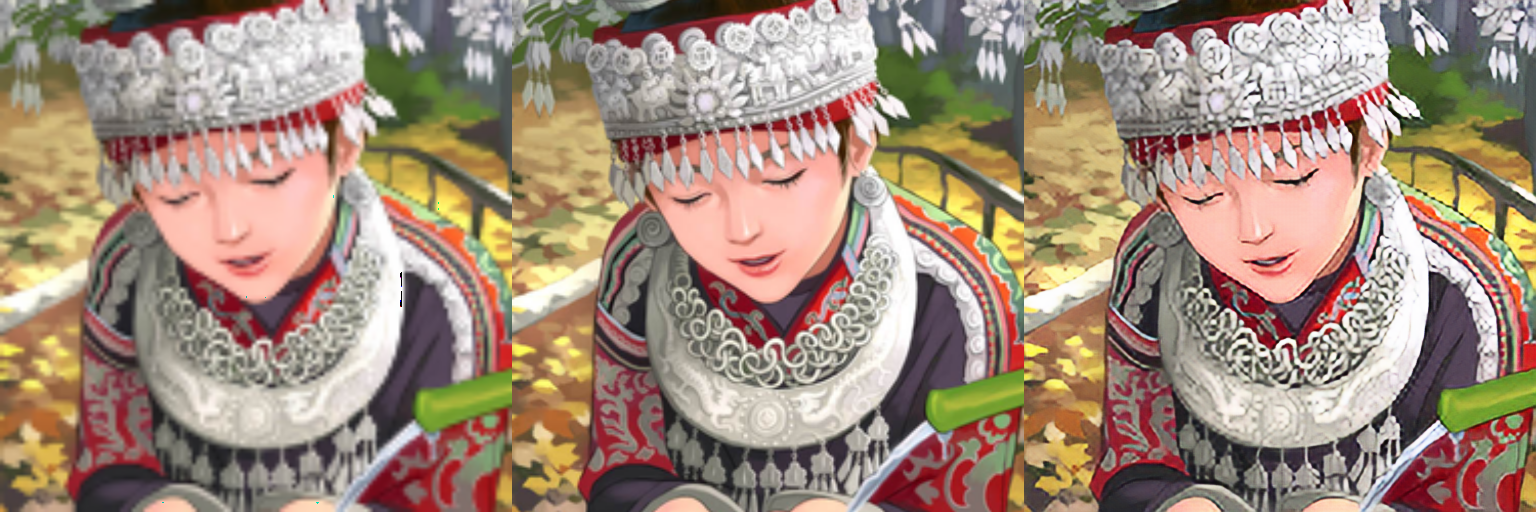

In [37]:
lr_img = Resize(512)(lr_img)
print(lr_img.shape, sr_img.shape, hr_img.shape)
log_img = torch.cat([lr_img, hr_img, sr_img[0],], dim=2)
print(log_img.shape)
log_img = ToPILImage()(log_img.cpu().detach())
display(log_img)